We want to calculate the joint entropy of infinitely finely spaced measurements of a 1-D random process, where the domain is bounded and the response is binned at resolution $1/\Delta r$. Specifically, given 

$$r(\tau) = [1 - e^{-1/\tau}]\sum_{m=0}^{\infty}e^{-m/\tau}s_m = [1 - a]\sum_{m=0}^\infty a^ms_m$$

where $\{s_m\}$ is an infinite binary string sampled from some distribution (e.g. i.i.d. Bernoulli variables) and $0 \leq a(\tau) = \exp(-1/\tau) \leq 1$, let $\mathbf{r} = [r_0, ..., r_L]$, $a_k = k/L$ with 

$$r_k \equiv r(-1/\log[a_k]) = r(-1/\log[k/L]) = [1 - k/L]\sum_{m=0}^{\infty}(k/L)^ms_m$$

Note $k/L = 0$ maps to $\tau = 0$ and $k/L = 1$ maps to $\tau = \infty$.

We want to compute

$$H[r(\tau)] \equiv \lim_{L \rightarrow \infty} H[r_0, ..., r_L].$$

This is related to the entropy rate but is not exactly the same thing.

First note that $H[r(\tau)]$ is finite. Since $r$ is a smooth function of $a$, eventually taking finer and finer measurements will yield no new information, since each measurement at $a_k$ will be almost identical to the measurement at $a_{k+1}$, and we need only consider $0 \leq a \leq 1$, so we are measuring $r$ over a bounded domain. 

Although $H[r(\tau)]$ may be analytically solvable for i.i.d. $s_m$, we would like a way to estimate it from a collection of samples of $r(\tau)$, so we can compare the i.i.d. case to when $\{s_m\}$ has higher order statistics. This is tricky, however, since $\mathbf{r}$ is high-dimensional and for most reasonable resolutions $1/\Delta r$, most of the $(1/\Delta r)^{L+1}$ bins will contain at most one sample.

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
from scipy import stats
import os
import sys

from disp import set_font_size, get_spaced_colors

First we'll sample a bunch of binary strings from different random processes. We use a balanced markov chain with switching probability $q$.

In [2]:
def sample_mkv(q, n_t):
    """Sample from balanced markov chain with switching probability q."""
    s_m = [np.random.binomial(1, .5)]
    for ct in range(1, n_t):
        s_m.append((1-s_m[ct-1]) if np.random.rand() < q else s_m[ct-1])
        
    return np.array(s_m).astype(bool)

In [3]:
NA = 100
A = np.linspace(0, 1, NA+1)[:-1]
M_MAX = int(round(-10/np.log(A[-1])))

print(f'a_min = {A[0]}, a_max = {A[-1]}, da = {np.mean(np.diff(A))}')
print(f'tau_min = {-1/np.log(A[0])}, tau_max = {-1/np.log(A[-1])}')
print(f'm_max = {M_MAX}')

a_min = 0.0, a_max = 0.99, da = 0.01
tau_min = 0.0, tau_max = 99.49916247342207
m_max = 995


In [4]:
NTR = int(1e6)
qs = np.linspace(0, 1, 11)
print(qs)

for q in qs:
    sys.stdout.write(f'q={q:.2f}')
    
    fname = f's_balanced_mkv_q_{q:.2f}_n_{NTR}.npy'
    if os.path.isfile(fname):
        sys.stdout.write('...file already exists.\n')
        continue
        
    s_mat = np.zeros((NTR, M_MAX), dtype=bool)

    for ctr in range(NTR):
        s_mat[ctr, :] = sample_mkv(q, M_MAX)
        if ctr % 10000 == 0:
            sys.stdout.write('.')

    np.save(fname, s_mat)
    print('')

[0.  0.1 0.2 0.3 0.4 0.5 0.6 0.7 0.8 0.9 1. ]
q=0.00...file already exists.
q=0.10...file already exists.
q=0.20...file already exists.
q=0.30...file already exists.
q=0.40...file already exists.
q=0.50...file already exists.
q=0.60...file already exists.
q=0.70...file already exists.
q=0.80...file already exists.
q=0.90...file already exists.
q=1.00...file already exists.


In [5]:
# convert binary sequences to population responses

In [6]:
def s2r(s, tau=None, a=None):
    """s should be (N x T), returns r (N x N_A), tau or a should be 1-D arrays"""
    assert (tau is not None) or (a is not None)
    
    n, t = s.shape
    
    if tau is not None:
        a = np.exp(-1/tau)
    
    assert a.ndim == 1
    n_a = len(a)
    
    a = np.tile(a[None, :], (t, 1))
    a_m = (1-a)*(a**np.tile(np.arange(t)[:, None], (1, n_a)))
    
    return s @ a_m


for q in qs:
    sys.stdout.write(f'q={q:.2f}...')
    fname = f's_balanced_mkv_q_{q:.2f}_n_{NTR}.npy'
    
    s_mat = np.load(fname)
    
    fname = f'r_balanced_mkv_q_{q:.2f}_n_{NTR}.npy'
    
    if os.path.isfile(fname):
        sys.stdout.write('file already exists.\n')
        continue
        
    r_mat = s2r(s_mat, a=A)
    np.save(fname, np.array([{'a': A, 'r': r_mat}]))
    print('')

q=0.00...file already exists.
q=0.10...file already exists.
q=0.20...file already exists.
q=0.30...file already exists.
q=0.40...file already exists.
q=0.50...file already exists.
q=0.60...file already exists.
q=0.70...file already exists.
q=0.80...file already exists.
q=0.90...file already exists.
q=1.00...file already exists.


9 bins...........
27 bins...........
81 bins...........
243 bins...........


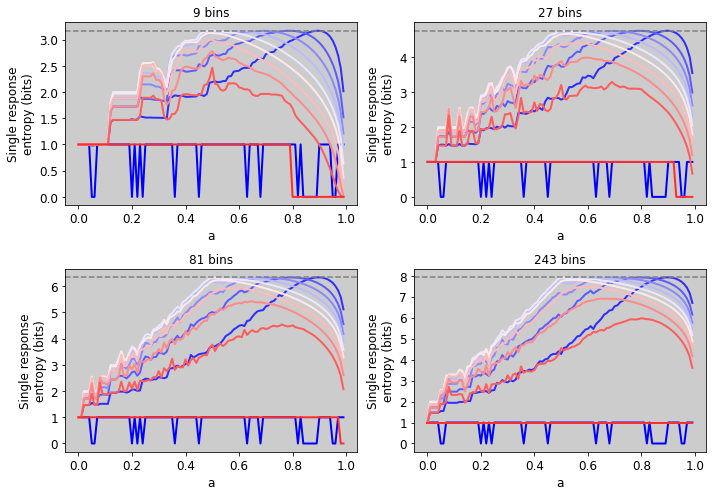

In [12]:
# compute marginal response entropies for each q
nbin_r = [9, 27, 81, 243]
fig, axs = plt.subplots(2, 2, figsize=(10, 7), tight_layout=True)

cs = get_spaced_colors('bwr', len(qs), step=1/len(qs))

for nbin_, ax in zip(nbin_r, axs.flatten()):
    sys.stdout.write(f'{nbin_} bins')
    bins = np.linspace(0, 1, nbin_+1)
    
    for q, c in zip(qs, cs):
        sys.stdout.write('.')
        
        fname = f'r_balanced_mkv_q_{q:.2f}_n_{NTR}.npy'
        
        temp = np.load(fname, allow_pickle=True)[0]
        
        a = temp['a']
        r = temp['r']
        
        h = np.nan * np.zeros(len(a))
        for ca, a_ in enumerate(a):
            cts = np.histogram(r[:, ca], bins=bins)[0]
            h[ca] = stats.entropy(cts/cts.sum(), base=2)
            
        ax.plot(a, h, c=c, lw=2)
        
    ax.axhline(np.log2(nbin_), color='gray', ls='--')
        
    ax.set_xlabel('a')
    ax.set_ylabel('Single response\nentropy (bits)')
    ax.set_title(f'{nbin_} bins')
    
    ax.set_facecolor((.8, .8, .8))
    print('')
    
set_font_size(axs, 12)

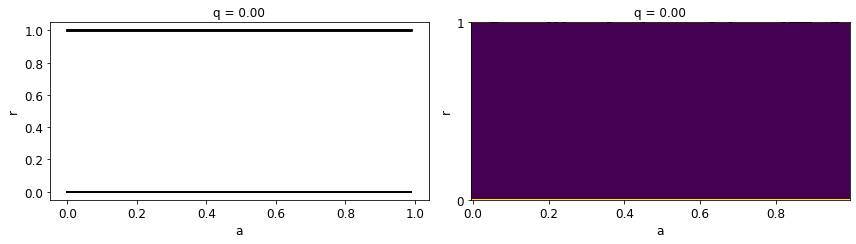

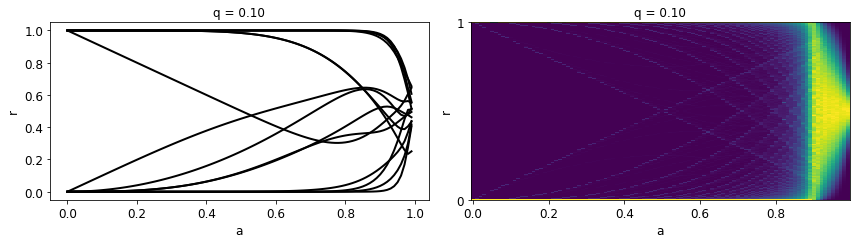

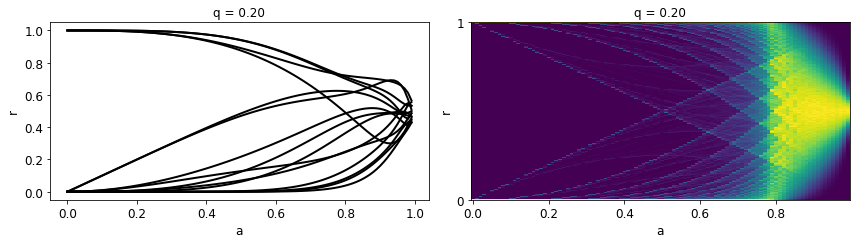

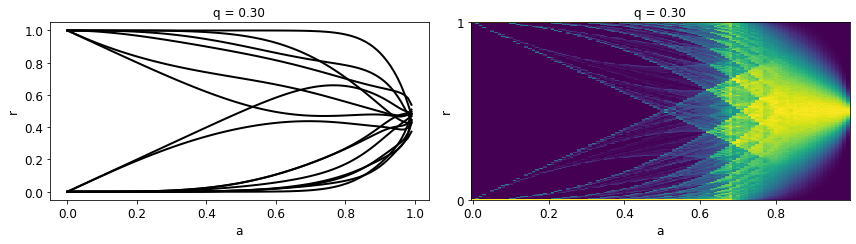

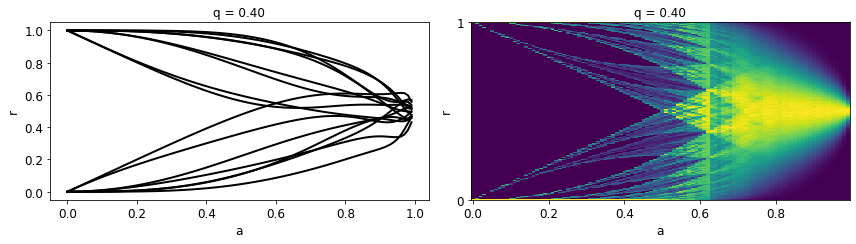

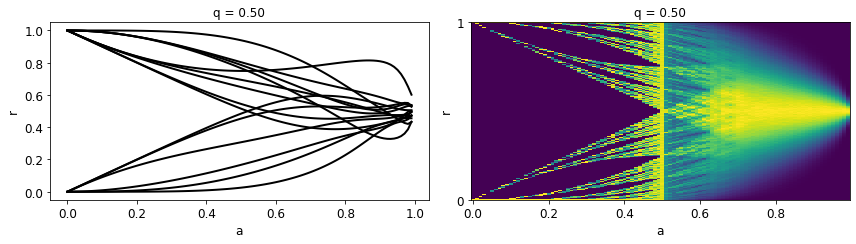

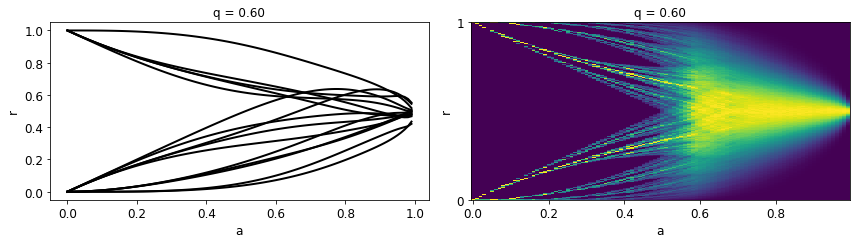

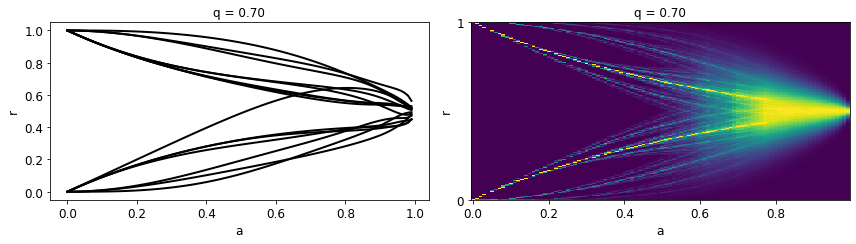

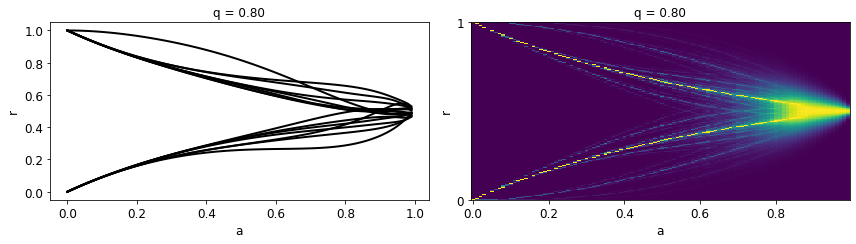

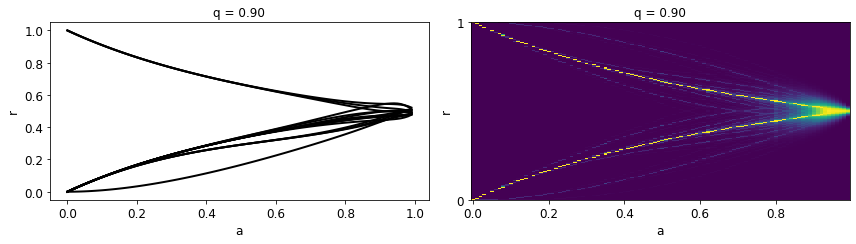

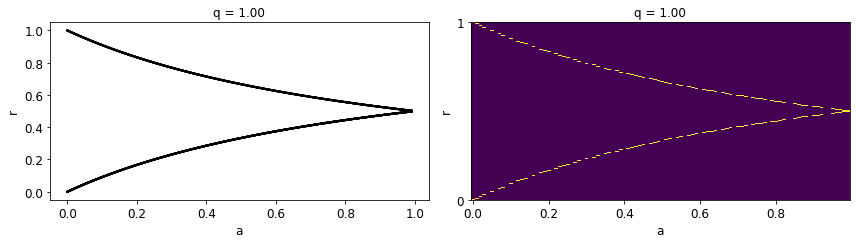

In [16]:
# plot sample population responses and marginal distributions for each q
nbin_r = 243
n_r_plt = 15

for q in qs:
    fname = f'r_balanced_mkv_q_{q:.2f}_n_{NTR}.npy'
        
    temp = np.load(fname, allow_pickle=True)[0]

    a = temp['a']
    r = temp['r']
    
    cts_normed = np.nan * np.zeros((nbin_r, len(a)))
    
    for ca, a_ in enumerate(a):
        ct_r = np.histogram(r[:, ca], np.linspace(0, 1, nbin_r+1))[0]
        cts_normed[:, ca] = ct_r/ct_r.max()

    da = np.mean(np.diff(a))
    
    fig, axs = plt.subplots(1, 2, figsize=(12, 3.5), tight_layout=True)
    axs[0].plot(a, r[:n_r_plt, :].T, c='k', lw=2)
    axs[1].matshow(cts_normed, origin='lower', extent=[a[0]-da/2, a[-1]+da/2, 0, 1])
    axs[1].xaxis.tick_bottom()
    axs[1].set_aspect('auto')
    
    for ax in axs:
        ax.set_xlabel('a')
        ax.set_ylabel('r')
        ax.set_title(f'q = {q:.2f}')
        
    set_font_size(axs, 12)

In [ ]:
from aux import sparse_hist_nd